# Undersampling and oversampling imbalanced data

# Introduction

Oftentimes in practical machine learning problems there will be significant differences in the rarity of different classes of data being predicted. For example, when detecting cancer we can expect to have datasets with large numbers of false outcomes, and a relatively smaller number of true outcomes.

The overall performance of any model trained on such data will be constrained by its ability to predict rare points. In problems where these rare points are only equally important or perhaps less important than non-rare points, this constraint may only become significant in the later "tuning" stages of building the model. But in problems where the rare points are important, or even the point of the classifier (as in a cancer example), dealing with their scarcity is a first-order concern for the mode builder.

Tangentially, note that the relative importance of performance on rare observations should inform your choice of error metric for the problem you are working on; the more important they are, the more your metric should penalize underperformance on them. See my previous Model Fit Metrics and Log Loss notebooks for slightly more detail on which error metrics do and don't care about this problem.

Several different techniques exist in the practice for dealing with imbalanced dataset. The most naive class of techniques is sampling: changing the data presented to the model by undersampling common classes, oversampling (duplicating) rare classes, or both.

# Motivation

We'll motivate why under- and over- sampling is useful with an example. The following visualization shows the radical effect that the relative number of points-per-class in a dataset has on classification as performed by a (linear-kernel) Support Vector Machine 

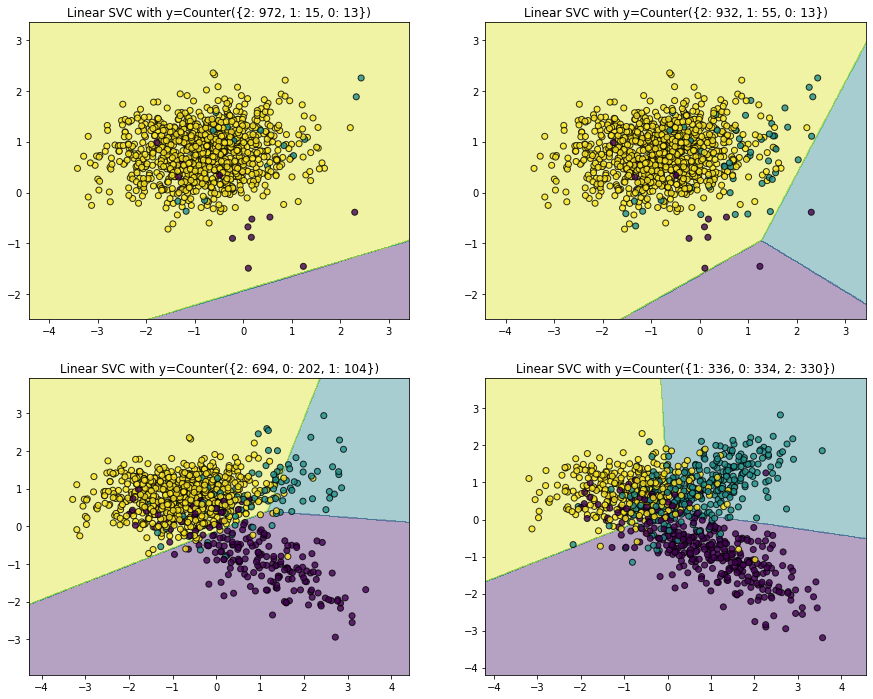

In [85]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification

def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))

As you can see, when a dataset is dominated by one or few classes, to the exclusion of some other classes, the optimal solution can break down to collapse: a model which simply classifies all or most points in the majority class (as in the first and second visualizations in this grid). However, as the number of observations per point approaches an equal split, the classifier becomes less and less biased.

Re-sampling points that are being fed into the model is the simplest way to fix model errors like this one stemming from rare class problems. Not all datasets have this issue, but for those that due, dealing with this issue is an important early step in modeling the data.

# Getting some sample data

We'll use the following data for the sake of illustration (taken from the sklearn documentation):

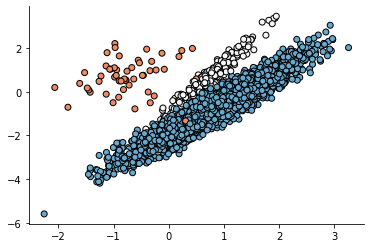

In [2]:
import seaborn as sns
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)
sns.despine()

# Raw over- and under- sampling

A group of researchers implemented the full suite of modern data sampling techniques with the imbalance-learn contrib module for sklearn. This submodule is installed as part of the base sklearn install by default, so it should be available to everyone. It comes with its own documentation as well; that is available here.

imblearn implements over-sampling and under-sampling using dedicated classes.



In [5]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

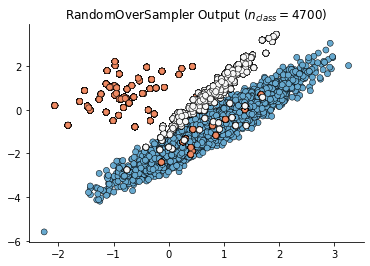

In [8]:
ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X_resampled, y_resampled = ros.fit_resample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomOverSampler Output ($n_{class}=4700)$")
pass

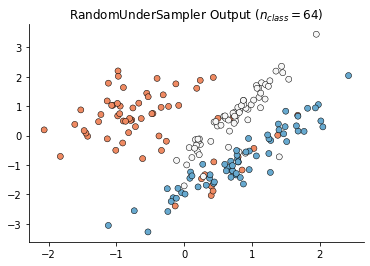

In [10]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass


In the first graph we have oversampled the dataset, duplicating points from the rare class 2 and the ultra rare class 3 in order to match the common class 1. This results in many points getting "pasted over" a huge number of times, as there are just 64 distinct points in class 2, but 4700 of them in class 1.

In the second graph we have undersampled the dataset. This goes the other way: classes 1 and 2 are reduced in numeric volume until they reach the same number of observations as class 3, at 64.

Which of these two fields of points are you better off training your classifier on? In extreme cases where the number of observations in the rare class(es) is really small, oversampling is better, as you will not lose important information on the distribution of the other classes in the dataset. For example, if there were just five observations in class 3, we'd have an awful time training a classifier on just 15 (5 times 3) undersampled points!

Outside of this case however, the performance of the one or the other will be most indistinguishable. Remember, sampling doesn't introduce new information in the dataset, it (hopefully) merely shifts it around so as to increase the "numerical stability" of the resulting models.



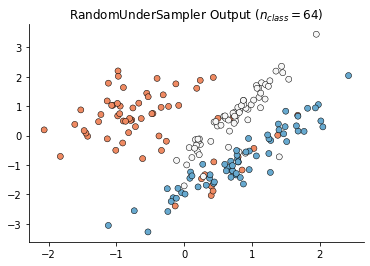

In [13]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

By default the number of observations will be balanced, e.g. each class will appear equally many times. There's also a ratio parameter, which allows you to choose the number of observations per class (in terms of integer absolute numbers, e.g. "60 class 1 observations") to push into your sample dataset. For example:



Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


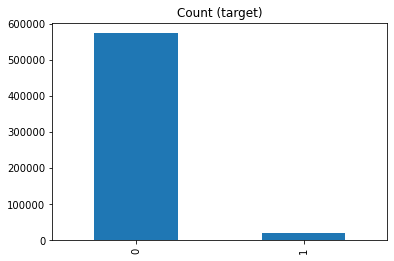

In [64]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

# The metric trap

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:



In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.35%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [42]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. In this competition, the evaluation metric is the Normalized Gini Coefficient, a more robust metric for imbalanced datasets, that ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score.

# Confusion matrix

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[114709      0]
 [  4334      0]]


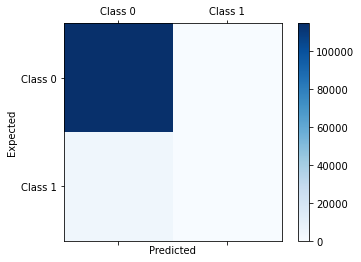

In [44]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

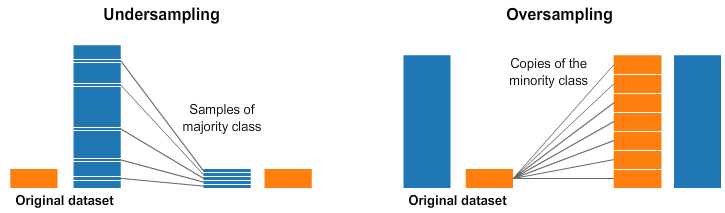

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Let's implement a basic example, which uses the DataFrame.sample method to get random samples each class:

In [65]:
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]


# Random under-sampling

Random under-sampling:
1    21694
0    21694
Name: target, dtype: int64


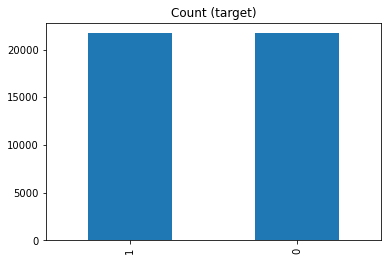

In [66]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

# Random over-sampling

Random over-sampling:
1    573518
0    573518
Name: target, dtype: int64


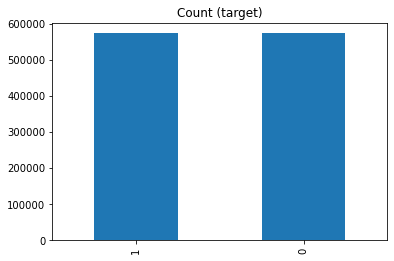

In [67]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

# Python imbalanced-learn module

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [68]:
import imblearn

For ease of visualization, let's create a small unbalanced sample dataset using the make_classification method:

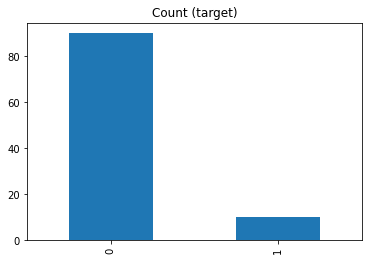

In [69]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:

In [70]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):



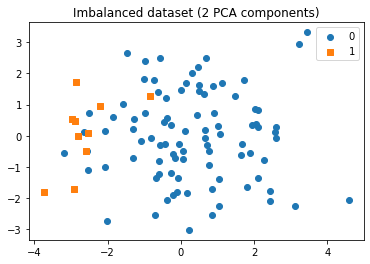

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

# Random under-sampling and over-sampling with imbalanced-learn

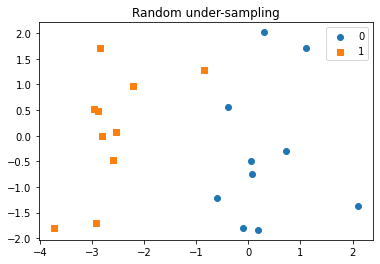

In [74]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X, y)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


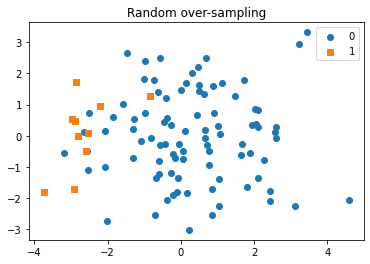

In [60]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

# Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

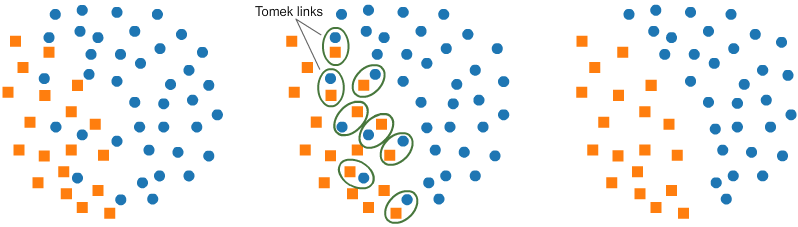



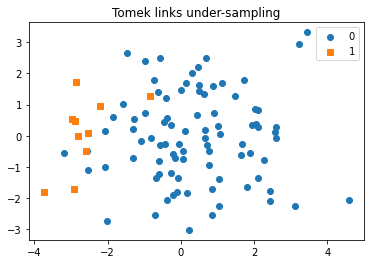

In [78]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X, y)


plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

# Under-sampling: Cluster Centroids

This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.



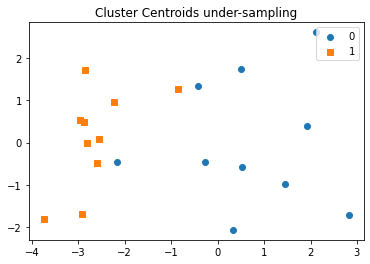

In [80]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

# Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

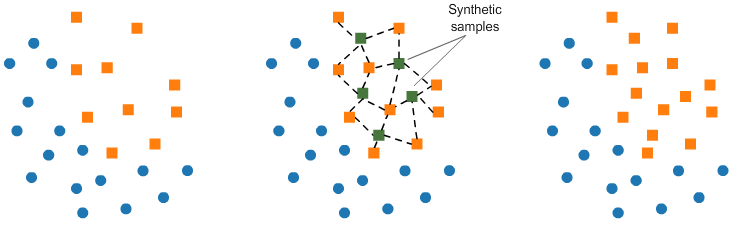

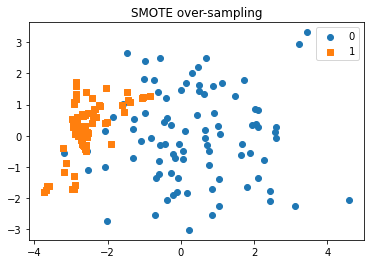

In [82]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

Over-sampling followed by under-sampling

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

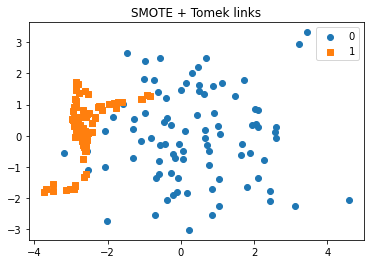

In [84]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')